<a href="https://colab.research.google.com/github/MariiaS/computer_vision/blob/main/Second_Project_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Third and forth task with Meanshift and CamShift.

Student: Mariia Solodiankina

The latest version of the code is stored by the link: https://colab.research.google.com/drive/1-mAqI50kZsbVYU4mMZ_mqD2Hh8jPiu3F?usp=sharing

Project README: 

So, we are going to try Meanshift and then as it's not perfect for our tesk with moving back and forth target, we will try Camshift. After this we will remove the face area and will try to detect the hand, as it's supposed to have the same hystogram as our face.
Steps:

**Meanshift**

1. First we need to setup the target, it is our face. In our case we select a bounding box around the face, and we use function `detect_faces()`, which using cascades detects a face area. We confirm the selected bounding box.
2. Then we find the histogram of the face so that we can backproject the target on each frame for calculation of meanshift. For histogram, only Hue is considered
3. To avoid false values due to low light, low light values are discarded using `cv2.inRange()` function. We use this mask to take into account only pixels which are not too bright and not too dark

**CamShift**
So, the thing about Meanshift that it doesn't change dynamically the rectangle of detected area, which is not great when the object moves back and forth. That's why we will use the CamShift, the idea behind it is: it applies meanshift first, once meanshift converges, it updates the size of the window.

**Forth task:** we put a black rectabgle on the area of the face and try to detect the hand.  We put 0 in the probability map called prob in Camshift code. As we can see the hand ii still detected as it suppose to have the same histogram as our face.



In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode

import numpy as np
from PIL import Image

import io
import cv2 # OpenCV library

In [2]:
cv2.__version__

'4.1.2'

In [3]:
from google.colab.output import eval_js

def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);
      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }

    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.20);

            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

In [4]:
def b64_to_bytes(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def bytes_to_b64(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

In [ ]:
# Load cascades using v2.CascadeClassifier(

In [5]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
!ls

--2021-03-14 19:27:59--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.06s   

2021-03-14 19:27:59 (15.2 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]

haarcascade_frontalface_default.xml  sample_data


In [10]:
faces_cascades = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [27]:
from google.colab.patches import cv2_imshow
def show_hist(hist):
  bin_count = hist.shape[0]
  bin_w = 24
  img = np.zeros((256, bin_count*bin_w, 3), np.uint8)
  for i in range(bin_count):
      h = int(hist[i])
      cv2.rectangle(img, (i*bin_w+2, 255), ((i+1)*bin_w-2, 255-h), (int(180.0*i/bin_count), 255, 255), -1)
  img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
  cv2_imshow(img)

In [8]:
def detect_faces(img, cascades):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = cascades.detectMultiScale(gray, 1.3, 4)
  return faces

In [49]:
VideoCapture()
eval_js('create()')

while True:
  response = input("Type anything when ready!:")
  byte = eval_js('capture()')
  im = b64_to_bytes(byte)
  im_copy = im.copy()
  faces = detect_faces(im, faces_cascades)

  if len(faces) == 1:
    face = faces[0]
    cv2.rectangle(im_copy,(face[0],face[1]),(face[0] + face[2], face[1] + face[3]),(0,255,0),2)
  else:
    continue

  eval_js('showimg("{}")'.format(bytes_to_b64(im_copy)))
  response = input("Use this bounding box? [y or n]:")
  if response == 'y':
    frame = im[face[1]:face[1]+face[3], face[0]:face[0]+face[2]]
    eval_js('showimg("{}")'.format(bytes_to_b64(frame)))
    tracking_window = face
    break

<IPython.core.display.Javascript object>

Type anything when ready!:Hi
Use this bounding box? [y or n]:y


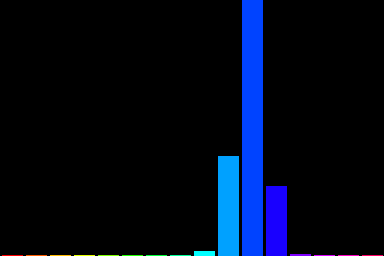

In [51]:
# Transform the frame into HSV
hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# Create an inRange mask for pixels. Limit the saturation in [64., 255.] and brightness in [32., 200.]
inrange_mask = cv2.inRange(hsv_frame, np.array((0., 60., 32.)), np.array((180., 255., 255.)))

# Compute the histogram of the frame (use only the HUE channel). See `https://bit.ly/3pdVUEd`
# Take into account only pixels which are not too bright and not too dark (use the previous mask)
# Use 16 bins and speicfy the range of the hue ([0, 180])

hist = cv2.calcHist( [hsv_frame], [0], inrange_mask, [16], [0, 180] )

# Normalize the histogram between 0 (lowest intensity) and 255 (highest intensity) (use MinMax normalization `cv.NORM_MINMAX`) using the method `https://bit.ly/3jMGhCj`

cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)

# Reashape the histogram into a 1-D array (use `.reshape(-1)`)

hist_reshaped = hist.reshape(-1)

# Show the histogram

show_hist(hist_reshaped)

#Mean-shift

<IPython.core.display.Javascript object>

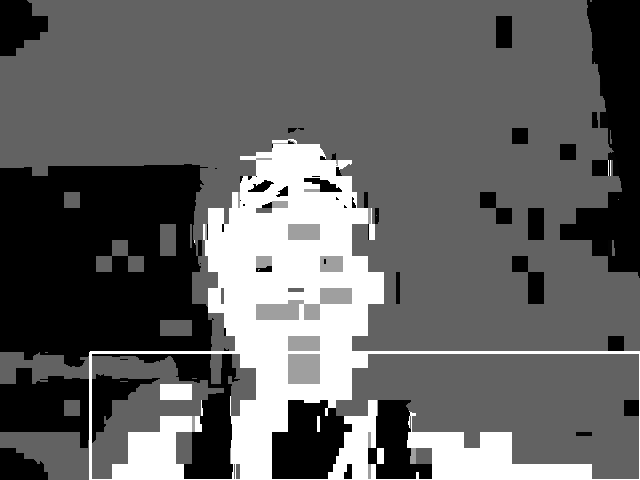

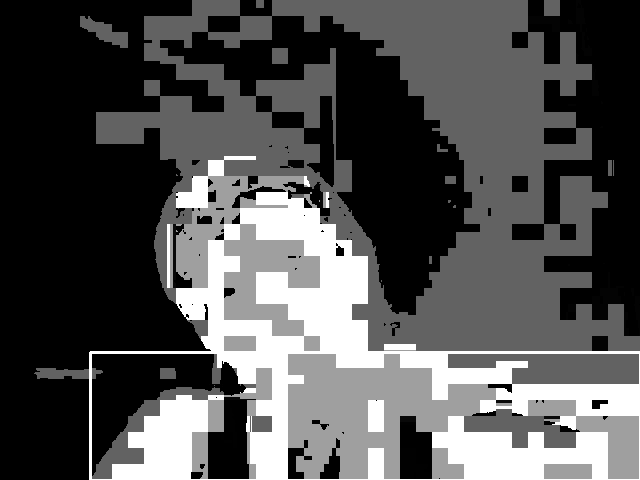

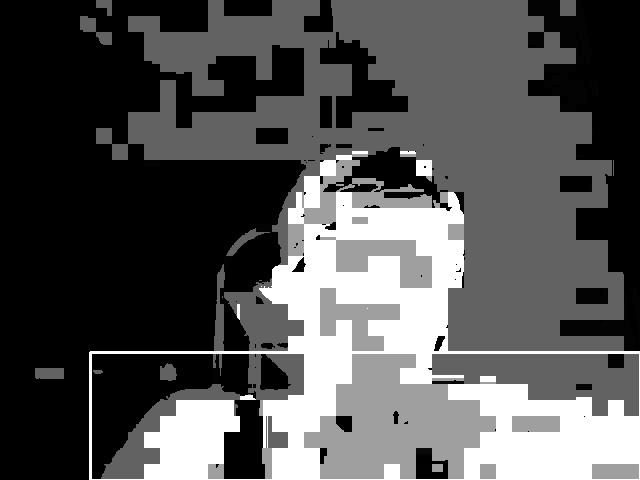

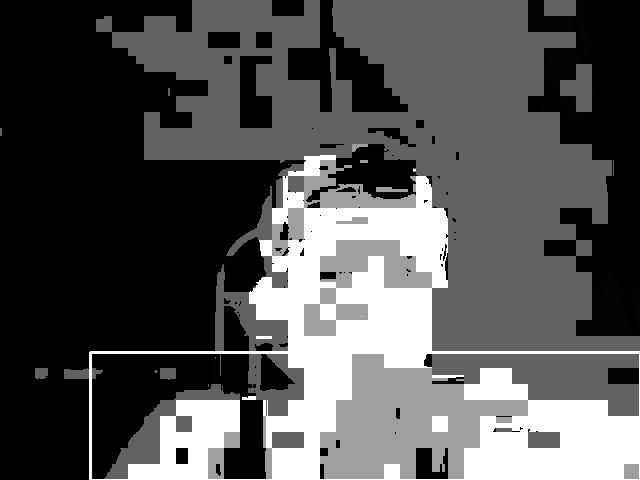

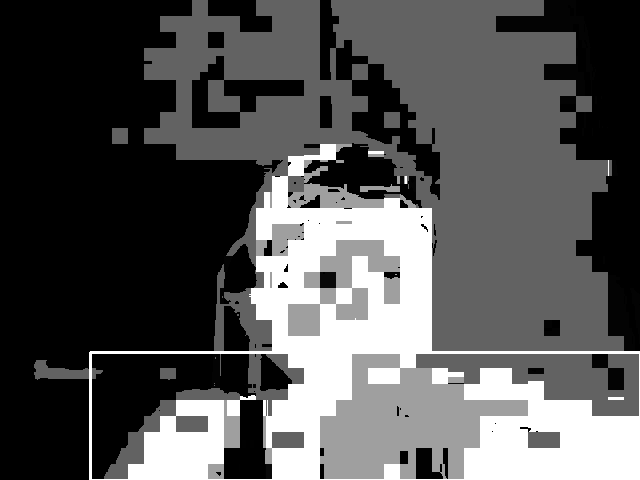

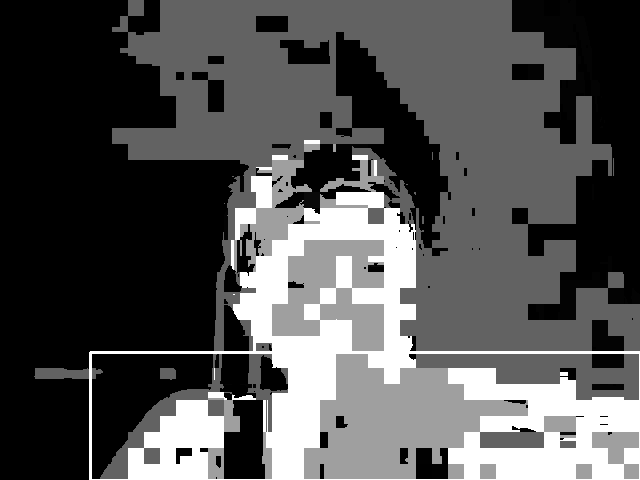

KeyboardInterrupt: ignored

In [45]:
VideoCapture()
eval_js('create()')

# These mean: Stop the mean-shift algorithm iff we effectuated 10 iterations or the computed mean does not change by more than 1pt ~ 1.3px in both directions
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while True:
  byte = eval_js('capture()') # Take a capture
  im = b64_to_bytes(byte)

  # Convert the capture in HSV

  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

  # Compute an inRange mask  as before with the frame
  inrange_mask = cv2.inRange(hsv, np.array((0., 60., 32.)), np.array((180., 255., 255.)))

  # Back project the frame histogram into the hsv image. Use only channel 0 (Hue), range of [0,180] and scale of 1
  prob = cv2.calcBackProject([hsv], [0], hist_reshaped, [0, 180], 1)

  # Bitwise and the back projection and the previously computed mask in order to remove very bright or very dark pixels (you can use `&` of python or cv2.bitwise_and in opencv)
  
  prob &= inrange_mask
  #
  _, tracking_window = cv2.meanShift(prob, tracking_window, term_crit)
  
  # plot a bounding box with coordiantes `tracking_window` in the image
  x,y,w,h = tracking_window
  img2 = cv2.rectangle(prob, (x,y), (x+w,y+h), 255,2)
  cv2_imshow(img2)

  eval_js('showimg("{}")'.format(bytes_to_b64(prob)))

### Cam-shift

In [33]:
VideoCapture()
eval_js('create()')

# These mean: Stop the mean-shift algorithm iff we effectuated 10 iterations or the computed mean does not change by more than 1pt ~ 1.3px in both directions
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while True:
  byte = eval_js('capture()') # Take a capture
  im = b64_to_bytes(byte)

  # Convert the capture in HSV

  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

  # Compute an inRange mask  as before with the frame
  inrange_mask = cv2.inRange(hsv, np.array((0., 60., 32.)), np.array((180., 255., 255.)))

  # Back project the frame histogram into the hsv image. Use only channel 0 (Hue), range of [0,180] and scale of 1
  prob = cv2.calcBackProject([hsv], [0], hist_reshaped, [0, 180], 1)

  # Bitwise and the back projection and the previously computed mask in order to remove very bright or very dark pixels (you can use `&` of python or cv2.bitwise_and in opencv)
  prob &= inrange_mask

  #
  bbox, tracking_window = cv2.CamShift(prob, tracking_window, term_crit)
  pts = cv2.boxPoints(bbox).astype(np.int)
  cv2.polylines(im, [pts], True, (255, 0 , 0), 2)
  eval_js('showimg("{}")'.format(bytes_to_b64(prob)))

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

## Forth task: erase the face 

In [54]:
VideoCapture()
eval_js('create()')

# These mean: Stop the mean-shift algorithm iff we effectuated 10 iterations or the computed mean does not change by more than 1pt ~ 1.3px in both directions
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
im_width, im_height = im.shape[1], im.shape[0]
tracking_window_box = (0,0,im_width, im_height)
while True:
  byte = eval_js('capture()') # Take a capture
  im = b64_to_bytes(byte)

  # Convert the capture in HSV

  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

  # Compute an inRange mask  as before with the frame
  inrange_mask = cv2.inRange(hsv, np.array((0., 60., 32.)), np.array((180., 255., 255.)))

  # Back project the frame histogram into the hsv image. Use only channel 0 (Hue), range of [0,180] and scale of 1
  prob = cv2.calcBackProject([hsv], [0], hist_reshaped, [0, 180], 1)

  # Bitwise and the back projection and the previously computed mask in order to remove very bright or very dark pixels (you can use `&` of python or cv2.bitwise_and in opencv)
  prob &= inrange_mask
  x,y,w,h = tracking_window
  prob[0:im_height, x - 50:x+w+50] = 0

  #
  bbox, tracking_window_box = cv2.CamShift(prob, tracking_window_box, term_crit)
  pts = cv2.boxPoints(bbox).astype(np.int)
  cv2.polylines(im, [pts], True, (255, 0 , 0), 2)
  eval_js('showimg("{}")'.format(bytes_to_b64(prob)))

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored